# IMPORT LIBRARIES

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
from IPython.display import display, clear_output
import tensorflow as tf
from tensorflow.keras import layers, models
import json
import os
import pydicom

# LOAD DATA

### LABEL DATA

In [4]:
#df_labels

pkl_p = 'C:/PROJECTS/emboendo/dicom_viewer/_static/labels_d.pkl'

if os.path.exists(pkl_p):df_labels= pd.read_pickle(pkl_p)
else: print('No Data')

df_labels

,Patient_ID,Sex,Age,S.E.,M.A.,A.C.V.,label
0,62,0,67,0,0,0,0
1,76,1,72,0,0,0,0
2,93,0,78,0,0,0,0
3,103,0,82,1,0,0,1
4,105,1,57,1,0,0,1
...,...,...,...,...,...,...,...
60,1311,1,73,0,0,0,0
61,1327,1,55,0,0,0,0
62,1340,1,73,0,0,0,0
63,1358,1,62,1,0,0,1


### VIDEO DATA

In [5]:
#json_d

SP_FILE_PATH = 'C:\PROJECTS\emboendo\dicom_viewer\_static\Jsons\points_fix_d.json'

if os.path.exists(SP_FILE_PATH ):
        
        with open(SP_FILE_PATH , 'r') as file:
            json_d=json.load(file)
            display(list(json_d.keys()))
        
else:print(' File does not exist')

['I0', 'I1040', 'I1060', 'I107', 'I213', 'I302', 'I349', 'I434', 'I70', 'I996']

### PATIENT DATA (NOT NEEDED)

In [6]:
# patient_data

"""MAIN_FILE_PATH = 'C:\PROJECTS\emboendo\Data\AnonymDAnon\DICOMDIR'
DS = pydicom.dcmread(MAIN_FILE_PATH)
patient_data = []
for record in DS.DirectoryRecordSequence:

    if record.DirectoryRecordType == 'PATIENT':
        patient_info = {
            'PatientID': record.PatientID,
            'Records':[element.ReferencedFileID[1] for element in record.children[0].children[0].children]}
        patient_data.append(patient_info)

patient_data=pd.DataFrame(patient_data)

patient_data"""

"MAIN_FILE_PATH = 'C:\\PROJECTS\\emboendo\\Data\\AnonymDAnon\\DICOMDIR'\nDS = pydicom.dcmread(MAIN_FILE_PATH)\npatient_data = []\nfor record in DS.DirectoryRecordSequence:\n\n    if record.DirectoryRecordType == 'PATIENT':\n        patient_info = {\n            'PatientID': record.PatientID,\n            'Records':[element.ReferencedFileID[1] for element in record.children[0].children[0].children]}\n        patient_data.append(patient_info)\n\npatient_data=pd.DataFrame(patient_data)\n\npatient_data"

GENERATE IMPUT_PATHS_SORTED:

In [7]:
#input_P_S

input_P_S={rec:{}for rec in json_d.keys()}

for R,frms in json_d.items():

    for ii in range(len(json_d[R].keys())):
        input_P_S[R][ii]=frms[str(ii)]["cropped_image"]

input_P_S

{'I0': {0: 'C:/PROJECTS/emboendo/Data/np_data_files/square_fixed/cropped\\I0_0.npy',
  1: 'C:/PROJECTS/emboendo/Data/np_data_files/square_fixed/cropped\\I0_1.npy',
  2: 'C:/PROJECTS/emboendo/Data/np_data_files/square_fixed/cropped\\I0_2.npy',
  3: 'C:/PROJECTS/emboendo/Data/np_data_files/square_fixed/cropped\\I0_3.npy',
  4: 'C:/PROJECTS/emboendo/Data/np_data_files/square_fixed/cropped\\I0_4.npy',
  5: 'C:/PROJECTS/emboendo/Data/np_data_files/square_fixed/cropped\\I0_5.npy',
  6: 'C:/PROJECTS/emboendo/Data/np_data_files/square_fixed/cropped\\I0_6.npy',
  7: 'C:/PROJECTS/emboendo/Data/np_data_files/square_fixed/cropped\\I0_7.npy',
  8: 'C:/PROJECTS/emboendo/Data/np_data_files/square_fixed/cropped\\I0_8.npy',
  9: 'C:/PROJECTS/emboendo/Data/np_data_files/square_fixed/cropped\\I0_9.npy',
  10: 'C:/PROJECTS/emboendo/Data/np_data_files/square_fixed/cropped\\I0_10.npy',
  11: 'C:/PROJECTS/emboendo/Data/np_data_files/square_fixed/cropped\\I0_11.npy',
  12: 'C:/PROJECTS/emboendo/Data/np_data_f

In [8]:
def obt_label(rec,df_labs):

    FILES_PATH = 'C:/PROJECTS/emboendo/Data/AnonymDAnon/DICOM/'
    filename = FILES_PATH + rec
    ds_file= pydicom.dcmread(filename)
    patientID=int(ds_file.PatientID)
    label=df_labs.loc[df_labs['Patient_ID'] == patientID,'label'].iloc[0]

    return int(label) , patientID


In [9]:
def load_video(in_d,rec,frms,lab):

    vd_ls=[]

    for ii in range(len(json_d[rec].keys())):

        image=np.load(frms[str(ii)]["cropped_image"])
        vd_ls.append(image)

    in_d[rec]['vd_d']=np.array(vd_ls)
    in_d[rec]['label']=lab
    
    return in_d

GENERATE VIDEO DICT:  input_d = { 'record name' : { 'vd_d' : [ narrays ], 'label' : int( 0 o 1) } }

In [10]:
#input_d

input_d={rec:{}for rec in json_d.keys()}
R_PI_RELATION={'Record':[],'label':[],'Patient ID':[],'Frames':[],'Shape':[]}

for R,frames in json_d.items():

    lab,patientID=obt_label(R,df_labels)
    input_c=input_d.copy()
    input_d=load_video(input_c,R,frames,lab)
    
    R_PI_RELATION['Record'].append(R)
    R_PI_RELATION['label'].append(lab)
    R_PI_RELATION['Patient ID'].append(patientID)
    R_PI_RELATION['Frames'].append(len(frames))
    R_PI_RELATION['Shape'].append(np.shape(input_d[R]['vd_d']))

In [11]:
# R_PI_RELATION
R_PI_RELATION=pd.DataFrame(R_PI_RELATION)
R_PI_RELATION= R_PI_RELATION.sort_values(by='Patient ID', ascending=True)
R_PI_RELATION


,Record,label,Patient ID,Frames,Shape
0,I0,0,62,39,"(39, 100, 100)"
8,I70,1,103,18,"(18, 100, 100)"
3,I107,0,106,21,"(21, 100, 100)"
4,I213,0,160,35,"(35, 100, 100)"
5,I302,0,224,35,"(35, 100, 100)"
6,I349,0,249,42,"(42, 100, 100)"
7,I434,0,781,19,"(19, 100, 100)"
9,I996,1,1054,17,"(17, 100, 100)"
1,I1040,0,1066,39,"(39, 100, 100)"
2,I1060,0,1089,24,"(24, 100, 100)"


### Video check

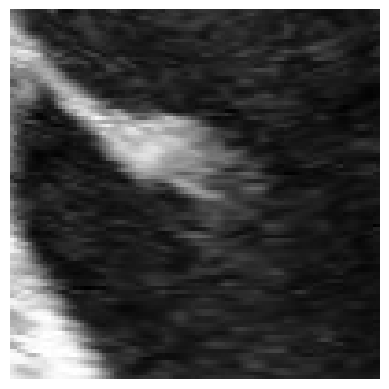

In [12]:
video_check,rec_check=True,'I0'

if video_check:
    
    t_btw_frm=0.2

    for ii in range(len(input_d[rec_check]['vd_d'])):

        imagen = input_d[rec_check]['vd_d'][ii]

        plt.imshow(imagen, cmap='gray')
        plt.axis('off')
        plt.show()
        time.sleep(t_btw_frm)
        clear_output(wait=True)

# Neural network

### GENERATE TRAIN DATA

In [13]:
max_frm_n=max([len(input_d[R]['vd_d']) for R in input_d.keys()])
x_train,y_train=[],[]

for R in input_d.keys():

    vd=input_d[R]['vd_d']
    vd = vd[:, :, :, np.newaxis]
    x_train.append(vd)
    y_train.append(input_d[R]['label'])

height, wide=np.shape(x_train[0])[1],np.shape(x_train[0])[1]

for i, video in enumerate(x_train):
    frames_actual = video.shape[0]
    if frames_actual < max_frm_n:
        
        padding = np.zeros((max_frm_n - frames_actual, height, wide, 1))
        x_train[i] = np.concatenate([video, padding], axis=0)
    elif frames_actual > max_frm_n:
        
        x_train[i] = video[:max_frm_n, :, :, :]

X_train = np.array(x_train)
Y_train = np.array(y_train)


### GENERATE MODEL

In [14]:
model = models.Sequential()

model.add(layers.TimeDistributed(layers.Conv2D(16, (3, 3), activation='relu'), input_shape=(max_frm_n, height, wide, 1)))
model.add(layers.TimeDistributed(layers.MaxPooling2D((2, 2))))

model.add(layers.TimeDistributed(layers.Conv2D(16, (3, 3), activation='relu')))
model.add(layers.TimeDistributed(layers.MaxPooling2D((2, 2))))

# Capa LSTM
model.add(layers.TimeDistributed(layers.Flatten()))
model.add(layers.LSTM(16))

# Capa densa de salida
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 42, 98, 98, 16)    160       
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 42, 49, 49, 16)    0         
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 42, 47, 47, 16)    2320      
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 42, 23, 23, 16)    0         
 stributed)                                                      
                                                                 
 time_distributed_4 (TimeDi  (None, 42, 8464)          0

### TRAIN

In [15]:
model.fit(X_train, Y_train, epochs=10, batch_size=32)

Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 0.7568 - accuracy: 0.3000
Epoch 2/10
1/1 [==============================] - 1s 587ms/step - loss: 0.6380 - accuracy: 0.8000
Epoch 3/10
1/1 [==============================] - 1s 580ms/step - loss: 0.6276 - accuracy: 0.8000
Epoch 4/10
1/1 [==============================] - 1s 531ms/step - loss: 0.5993 - accuracy: 0.8000
Epoch 5/10
1/1 [==============================] - 1s 542ms/step - loss: 0.5872 - accuracy: 0.8000
Epoch 6/10
1/1 [==============================] - 1s 554ms/step - loss: 0.5833 - accuracy: 0.8000
Epoch 7/10
1/1 [==============================] - 1s 579ms/step - loss: 0.5621 - accuracy: 0.8000
Epoch 8/10
1/1 [==============================] - 1s 555ms/step - loss: 0.5474 - accuracy: 0.8000
Epoch 9/10
1/1 [==============================] - 1s 574ms/step - loss: 0.5353 - accuracy: 0.8000
Epoch 10/10
1/1 [==============================] - 1s 577ms/step - loss: 0.5246 - accuracy: 0.8000


### MODEL PREDICTION